# Performance Analysis of KOOC for a Simple Pendulum

In this notebook, we demonstrate Koopman Operator Optimal Control (KOOC) for a simple pendulum, globally linearized using a Linearly Recurrent Encoder Network (LREN) and a Deep Encoder with Initial State parameterisation network (DENIS). The performance difference between the two is compared. We also utilize a local linearization control method i.e. iterative LQR (iLQR) and model predictive control (MPC) on the Koopman Invariant Subspace.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate, signal
from scipy.integrate import odeint
import harold
from control import *
import torch


os.chdir("../")

from helper_fn import *
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

## DENIS VS LREN Open Loop Comparision

The pendulum is simulated without control input

In [88]:
val_data = torch.tensor(np.load("data/pendulum_val.npy")).float()
denis = torch.load("logs/denis_pendulum/model-denis-pend-best.pt", map_location=torch.device('cpu'))
lren = torch.load("logs/lren_pendulum/model-lren-pend-best.pt", map_location=torch.device('cpu'))

In [89]:
enc_gt_de, enc_traj_de, ko_all = denis(val_data)
enc_gt_lr, enc_traj_lr = lren(val_data)
val_data = val_data.detach().numpy()

In [90]:
idx = np.random.randint(val_data.shape[0])
init = val_data[idx, 0, :]
print("Random Initial: {}".format(init))

Random Initial: [-0.7007784  1.3449968]


In [91]:
# get initial encodings
enc_init_de = enc_traj_de[idx, 0, :].detach().numpy()
enc_init_lr = enc_traj_lr[idx, 0, :].detach().numpy()

# get koopman operators
ko = ko_all[idx].detach().numpy()
ko_lren = list(lren.parameters())[-1].detach().numpy()

pred_de = [enc_init_de]
pred_lr = [enc_init_lr]
n_steps = 500

for i in range(n_steps):
    pred_de.append(np.matmul(pred_de[-1], ko))
    pred_lr.append(np.matmul(pred_lr[-1], np.transpose(ko_lren)))
    
pred_de = np.asarray(pred_de)[:, :2]
pred_lr = np.asarray(pred_lr)[:, :2]

t = np.arange(0, n_steps*0.1+0.1, 0.1)

Equvalent to ODE45 in MATLAB so solve for the pendulum system

In [92]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, - c*np.sin(theta)]
    return dydt

b = 0.25
c = 1.0
y0 = init

sol = odeint(pend, y0, t, args=(b, c))

We see clearly that DENIS outperforms LREN with open loop

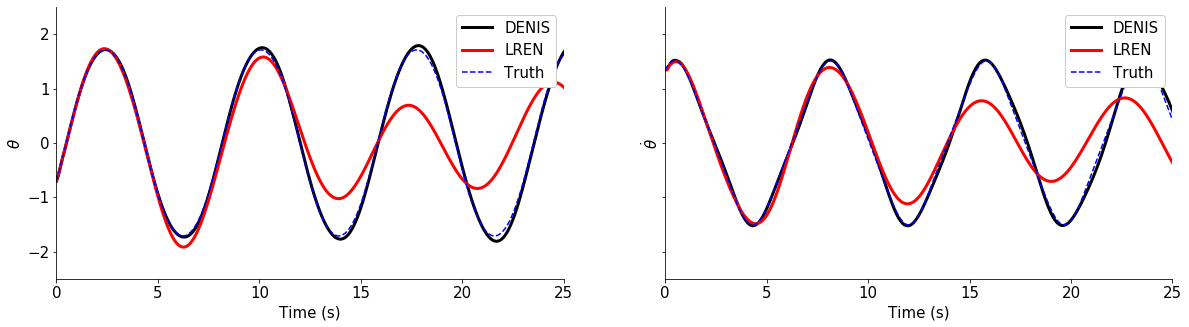

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)

ax[0].plot(t, pred_de[:,0], label=r"DENIS", linewidth=3, color='k')
ax[0].plot(t, pred_lr[:,0], label=r"LREN", linewidth=3, color='r')
ax[0].plot(t, sol[:,0],'--', label=r"Truth", color='b')

ax[1].plot(t, pred_de[:,1], label=r"DENIS", linewidth=3, color='k')
ax[1].plot(t, pred_lr[:,1], label=r"LREN", linewidth=3, color='r')
ax[1].plot(t, sol[:,1], '--', label=r"Truth", color='b')

ax[0].set_ylabel(r"$\theta$")
ax[1].set_ylabel(r"$\dot{\theta}$")

for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].legend(loc=1, facecolor='white', framealpha=1)
    ax[i].set_xlim([0, 25])
    ax[i].set_ylim([-2.5, 2.5])
    ax[i].set_xlabel("Time (s)")

plt.savefig('figures/denis_vs_lh_1d.png', bbox_inches='tight', dpi=200)
plt.show()

Animation generation for the two systems

## Close Loop Control (KOOC)

First, we use Tustin transform to convert our discrete system into a continous system, sampling time set to system's time-advance steps

In [95]:
A_de = np.transpose(ko.copy())
#A_de = ko.copy()
A_lr = np.transpose(ko_lren.copy())
dim = 2

ldim_de = len(enc_init_de) - dim
ldim_lr = len(enc_init_lr) - dim

Ts = 0.1

B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

C_de = np.append([1, 1], np.zeros((1, ldim_de)))
C_lr = np.append([1, 1], np.zeros((1, ldim_lr)))

#dsys_de = signal.StateSpace(A_de, B_de, C_de, .0, dt=Ts)
#dsys_lr = signal.StateSpace(A_lr, B_lr, C_lr, .0, dt=Ts)

G_de = harold.State(A_de, B_de, C_de, .0, dt=Ts)
G_lr = harold.State(A_lr, B_lr, C_lr, .0, dt=Ts)

sys_de = harold.undiscretize(G_de, 'tustin')
sys_lr = harold.undiscretize(G_lr, 'tustin')

As_de = sys_de.a
As_lr = sys_lr.a

Eigenvalues are visualized, we expect pair wise eigenvalues $\pm j$ which corresponds to the pure rotation term

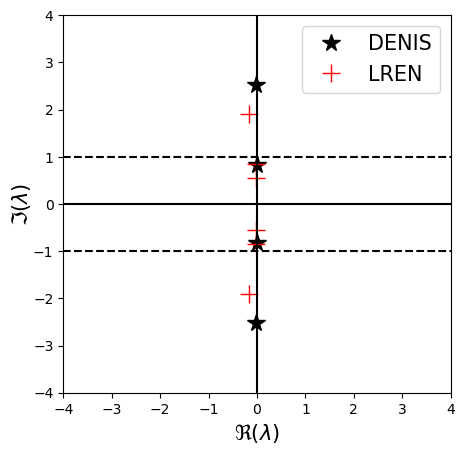

In [96]:
eigA_de = np.linalg.eig(As_de)[0]
eigA_lr = np.linalg.eig(As_lr)[0]

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.real(eigA_de), np.imag(eigA_de), '*', label='DENIS', color='k', markersize=13)
plt.plot(np.real(eigA_lr), np.imag(eigA_lr), '+', label='LREN', markersize=13, color='r')


plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.axhline(y=1, linestyle='dashed', color='k')
plt.axhline(y=-1, linestyle='dashed', color='k')

plt.xlabel(r"$\Re(\lambda)$")
plt.ylabel(r"$\Im(\lambda)$", labelpad=0)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.xlim([-4, 4])
plt.ylim([-4, 4])
#plt.xticks([-100, -50, 0])
#plt.yticks(np.arange(-100, 150, 50))

plt.legend(loc=1)
plt.savefig('figures/denis_vs_lh_eigenvalues_zoomed.png', bbox_inches='tight', dpi=200)

plt.show()

In [97]:
from control import *

Q_de = np.zeros((A_de.shape));
Q_de[0,0] = 1;
Q_de[1,1] = 1;

Q_lr = np.zeros((A_lr.shape));
Q_lr[0,0] = 1;
Q_lr[1,1] = 1;

B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

K_de, S_de, E_de = lqr(As_de, B_de, Q_de, 1)

denis.params['n_shifts'] = 1
lren.params['n_shifts'] = 1
K_lr, S_lr, E_lr = lqr(As_lr, B_lr, Q_lr, 1.)

In [98]:
def pendulum_de(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj, _ = denis(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    de_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

def pendulum_lr(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj = lren(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    lr_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

In [99]:
t1 = np.arange(0, 10, 0.01)

In [100]:
y0 = init.copy()
de_u = []
lr_u = []
sol_de = odeint(pendulum_de, y0, t1, args=(K_de,))
sol_lr = odeint(pendulum_lr, y0, t1, args=(K_lr,))

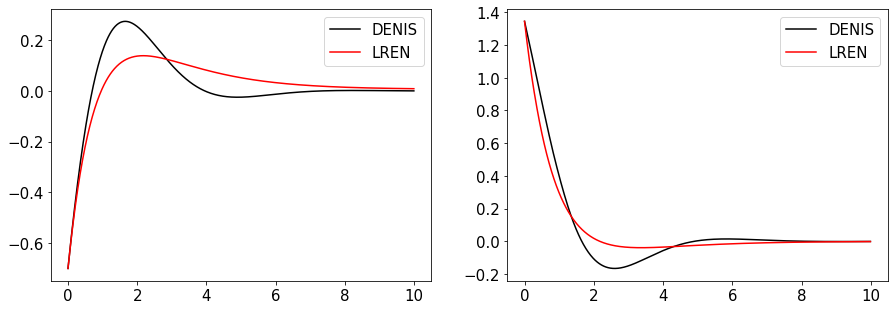

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
ax[0].plot(t1, sol_de[:, 0], 'k', label='DENIS')
ax[0].plot(t1, sol_lr[:, 0], 'r', label='LREN')
ax[0].legend()

ax[1].plot(t1, sol_de[:, 1], 'k', label='DENIS')
ax[1].plot(t1, sol_lr[:, 1], 'r', label='LREN')
ax[1].legend()

plt.show()

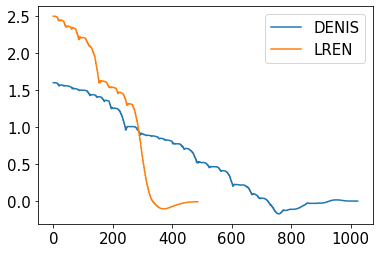

In [102]:
plt.plot(de_u, label='DENIS')
plt.plot(lr_u, label='LREN')
plt.legend()
plt.show()